In [3]:
import matplotlib.pyplot as plt
import numpy as np
import torch
import torch.nn as nn
from torch.utils.data import DataLoader
from numpy import random
import configparser
from text_processing import read_data_from_folder, get_word_count, map_words_to_index, pad_and_truncate_reviews
from utils import SentimentDataset, SentimentLSTM, accuracy
from test_utils import process_test_reviewx, predict_sentiment

In [4]:
# Read the INI configuration file
config = configparser.ConfigParser()
config.read("config.ini")

# Get the values for text processing
SEQUENCE_MAX_CUTOFF_LENGTH = int(config["TEXT_PROCESSING"]["SEQUENCE_MAX_CUTOFF_LENGTH"]) # Used review length analysis to get the value
SEQUENCE_MIN_CUTOFF_LENGTH = int(config["TEXT_PROCESSING"]["SEQUENCE_MIN_CUTOFF_LENGTH"])  # All reviews need to be greater than this


# Model Params & Training Params
LEARNING_RATE = float(config["MODEL_TRAINING"]["LEARNING_RATE"])
EPOCHS = int(config["MODEL_TRAINING"]["EPOCHS"])
CLIP = int(config["MODEL_TRAINING"]["CLIP"])
BATCH_SIZE = int(config["MODEL_TRAINING"]["BATCH_SIZE"])

# Model Hyperparameters
OUTPUT_SIZE = int(config["MODEL_HYPERPARAMS"]["OUTPUT_SIZE"])
EMBEDDING_DIM = int(config["MODEL_HYPERPARAMS"]["EMBEDDING_DIM"])
LSTM_HIDDEN_DIM = int(config["MODEL_HYPERPARAMS"]["LSTM_HIDDEN_DIM"])
LSTM_NLAYERS = int(config["MODEL_HYPERPARAMS"]["LSTM_NLAYERS"])
DROP_PROP = float(config["MODEL_HYPERPARAMS"]["DROP_PROP"])


device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

## 01. Read the data

In [5]:
# ### read all the data in a folder. Output is a tuple(list[reviews], list[ratings])

train_pos_reviews, train_pos_ratings  = read_data_from_folder(folderpath = "train/pos")
train_neg_reviews, train_neg_ratings  = read_data_from_folder(folderpath = "train/neg")
test_pos_reviews, test_pos_ratings  = read_data_from_folder(folderpath = "test/pos")
test_neg_reviews, test_neg_ratings  = read_data_from_folder(folderpath = "test/neg")

In [6]:
### get training and test datasets by combining pos and neg data

train_reviews = train_pos_reviews + train_neg_reviews
train_ratings = train_pos_ratings + train_neg_ratings
test_reviews = test_pos_reviews + test_neg_reviews
test_ratings = test_pos_ratings + test_neg_ratings

In [7]:
### Get a perspective of data shape
print("Total count of rating reviews foir training", len(train_reviews))
print("Total count of rating ratings foir training", len(train_ratings))
print("Total count of rating reviews foir testing", len(test_reviews))
print("Total count of rating ratings foir testing", len(test_ratings))

## 02. Tokenise the data - Reviews and Ratings

* Map the words in the reviews to some integer indexing
* Similarly map the ratings to binary values

In [8]:
### Get a word count dictionary

words_count = get_word_count(train_reviews)
distinct_words_total = len(words_count)

words_count_sorted = words_count.most_common(distinct_words_total)

In [9]:
### Get a mapper to map words to integer indexes
### As we are going to do padding for shorter reviews and conventional choice for padding is 0. So we need to start this indexing from 1. OOV words in test dataset are dropped


## Create a mapping of words to index
vocab_to_int = {word:i+1 for i, (word,_) in enumerate(words_count_sorted)}

## map the words to index in train and test reviews
train_reviews_encoded = [map_words_to_index(review, vocab_to_int) for review in train_reviews]
test_reviews_encoded = [map_words_to_index(review, vocab_to_int) for review in test_reviews]

## encode the labels as well
train_ratings_encoded = [1 if rating >= 7 else 0 for rating in train_ratings]
test_ratings_encoded = [1 if rating >= 7 else 0 for rating in test_ratings]

## 03. Padding/ Truncating the reviews for training

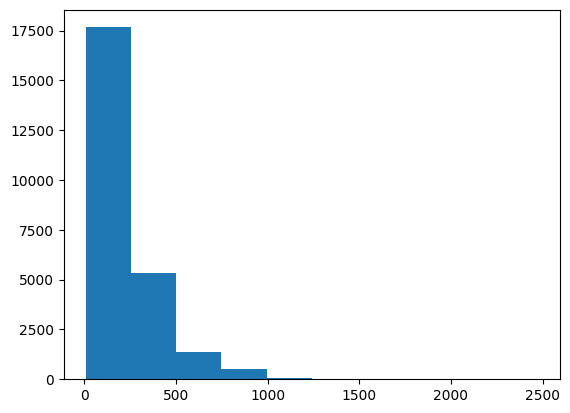

In [ ]:
### Get a grasp of review lengths for training in batches

train_reviews_length = [len(re) for re in train_reviews_encoded]

plt.hist(train_reviews_length)
plt.show()

In [ ]:
### Get basic statistics

print("Mean of the review length:", int(np.mean(train_reviews_length)))
print("25th percentile of the review length:", np.percentile(train_reviews_length, 25))
print("50th percentile of the review length:", np.percentile(train_reviews_length, 50))
print("75th percentile of the review length:", np.percentile(train_reviews_length, 75))

Mean of the review length: 233
25th percentile of the review length: 127.0
50th percentile of the review length: 174.0
75th percentile of the review length: 284.0


In [10]:
### Guess a review length of 256 should be good enough
### Remove review of length 0, if there

train_reviews_encoded = [train_reviews_encoded[index] for index, length in enumerate(train_reviews_length) if length >= SEQUENCE_MIN_CUTOFF_LENGTH]
train_ratings_encoded = [train_ratings_encoded[index] for index, length in enumerate(train_reviews_length) if length >= SEQUENCE_MIN_CUTOFF_LENGTH]

In [11]:
### For reviews shorter than SEQUENCE_LENGTH, we will pad with 0s. For reviews longer than seq_length we will truncate them to the first SEQUENCE_LENGTH words. SEQUENCE_LENGTH is same as number of timesteps in LSTM

# pad/ truncate the reviews to a uniform size of SEQUENCE_LENGTH. Output id array of shape #num_reviews * SEQUENCE_LENGTH
train_reviews_encoded_arr = pad_and_truncate_reviews(train_reviews_encoded, SEQUENCE_MAX_CUTOFF_LENGTH)

## 04. Train validation split

In [12]:
### As first 12500 reviews are positive and next 12500 reviews are negative. I have to uniquely select the reviews to ensure 50-50 balance of reviews in train and validation

split_frac = 0.8

train_index = np.concatenate(
    (random.choice(list(range(0,12500)), size = int(split_frac*12500), replace= False),
     random.choice(list(range(12500,25000)), size = int(split_frac*12500), replace= False),
    ), axis = 0)

validation_index = np.setdiff1d(np.array(list(range(0,25000))), train_index)


# Get the train and validation dataset
train_reviews_encodedX = np.take(train_reviews_encoded_arr, train_index, axis= 0)
train_ratings_encodedy = np.take(np.array(train_ratings_encoded, dtype = int), train_index, axis= 0)

valid_reviews_encodedX = np.take(train_reviews_encoded_arr, validation_index, axis= 0)
valid_ratings_encodedy = np.take(np.array(train_ratings_encoded, dtype = int), validation_index, axis= 0)

In [13]:
# create custom Dataset and Dataloader for train and validation data

train_dataset = SentimentDataset(train_reviews_encodedX, train_ratings_encodedy)
train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True)


valid_dataset = SentimentDataset(valid_reviews_encodedX, valid_ratings_encodedy)
valid_loader = DataLoader(valid_dataset, batch_size=BATCH_SIZE, shuffle=True)

In [14]:
# Dump numpy array to npy file to train on colab. SKip if system has GPU
np.save("train_reviews_encodedX.npy", train_reviews_encodedX)
np.save("train_ratings_encodedy.npy", train_ratings_encodedy)
np.save("valid_reviews_encodedX.npy", valid_reviews_encodedX)
np.save("valid_ratings_encodedy.npy", valid_ratings_encodedy)

train_reviews_encodedX = np.load("train_reviews_encodedX.npy")
train_ratings_encodedy = np.load("train_ratings_encodedy.npy")
valid_reviews_encodedX = np.load("valid_reviews_encodedX.npy")
valid_ratings_encodedy = np.load("valid_ratings_encodedy.npy")

## 05. Create a model instanse

In [15]:
model = SentimentLSTM(vocab_size = len(vocab_to_int),
                      output_size = OUTPUT_SIZE,
                      embedding_dim = EMBEDDING_DIM,
                      hidden_dim = LSTM_HIDDEN_DIM,
                      n_layers = LSTM_NLAYERS,
                      drop_prob=DROP_PROP)

print(model)

## 06. Training

In [16]:

# loss and optimization functions
lr= LEARNING_RATE
criterion = nn.BCELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=lr)

# training params
epochs = EPOCHS # 3-4 is approx where I noticed the validation loss stop decreasing
clip= CLIP # gradient clipping

In [17]:
# train loops

epoch_tr_loss,epoch_vl_loss = [],[]
epoch_tr_acc,epoch_vl_acc = [],[]


for epoch in range(epochs):
    train_losses = []
    train_acc = 0.0
    model.train()
    # initialize hidden state
    h = model.init_hidden(BATCH_SIZE)
    for inputs, labels in train_loader:

        inputs, labels = inputs.to(device), labels.to(device)
        # Creating new variables for the hidden state, otherwise
        # we'd backprop through the entire training history
        h = tuple([each.data for each in h])

        model.zero_grad()
        output,h = model(inputs,h)

        # calculate the loss and perform backprop
        loss = criterion(output.squeeze(), labels.float())
        loss.backward()
        train_losses.append(loss.item())
        # calculating accuracy
        acc = accuracy(output,labels)
        train_acc += acc
        #`clip_grad_norm` helps prevent the exploding gradient problem in RNNs / LSTMs.
        nn.utils.clip_grad_norm_(model.parameters(), clip)
        optimizer.step()

    val_h = model.init_hidden(BATCH_SIZE)
    val_losses = []
    val_acc = 0.0
    model.eval()
    for inputs, labels in valid_loader:
            val_h = tuple([each.data for each in val_h])


            inputs, labels = inputs.to(device), labels.to(device)


            output, val_h = model(inputs, val_h)
            val_loss = criterion(output.squeeze(), labels.float())


            val_losses.append(val_loss.item())

            acc = accuracy(output,labels)
            val_acc += acc

    epoch_train_loss = np.mean(train_losses)
    epoch_val_loss = np.mean(val_losses)
    epoch_train_acc = train_acc/len(train_loader.dataset)
    epoch_val_acc = val_acc/len(valid_loader.dataset)
    epoch_tr_loss.append(epoch_train_loss)
    epoch_vl_loss.append(epoch_val_loss)
    epoch_tr_acc.append(epoch_train_acc)
    epoch_vl_acc.append(epoch_val_acc)
    print(f'Epoch {epoch+1}')
    print(f'train_loss : {epoch_train_loss} val_loss : {epoch_val_loss}')
    print(f'train_accuracy : {epoch_train_acc*100} val_accuracy : {epoch_val_acc*100}')

## 07. Model weight saving & Testing

In [18]:
# save the model weights. Saved on GPU and to be loaded on GPU

torch.save(model.state_dict(), "LSTM_Sentimentanalysis.pth")

In [19]:
# load the model weights
test_model = SentimentLSTM(vocab_size = len(vocab_to_int) +1, # len(vocab_to_int) +1 for zero,
                      output_size = OUTPUT_SIZE,
                      embedding_dim = EMBEDDING_DIM,
                      hidden_dim = LSTM_HIDDEN_DIM,
                      n_layers = LSTM_NLAYERS,
                      drop_prob=DROP_PROP)


test_model.load_state_dict(torch.load("LSTM_Sentimentanalysis.pth", map_location=device))
print(test_model)

In [20]:
# test on a sample review

neg_review = "This is a pale imitation of 'Officer and a Gentleman.' There is NO chemistry between Kutcher and the unknown woman who plays his love interest. The dialog is wooden, the situations hackneyed. It's too long and the climax is anti-climactic(!). I love the USCG, its men and women are fearless and tough. The action scenes are awesome, but this movie doesn't do much for recruiting, I fear. The script is formulaic, but confusing. Kutcher's character is trying to redeem himself for an accident that wasn't his fault? Costner's is raging against the dying of the light, but why? His 'conflict' with his wife is about as deep as a mud puddle. I saw this sneak preview for free and certainly felt I got my money's worth."

pos_review = "I went and saw this movie last night after being coaxed to by a few friends of mine. I'll admit that I was reluctant to see it because from what I knew of Ashton Kutcher he was only able to do comedy. I was wrong. Kutcher played the character of Jake Fischer very well, and Kevin Costner played Ben Randall with such professionalism. The sign of a good movie is that it can toy with our emotions. This one did exactly that. The entire theater (which was sold out) was overcome by laughter during the first half of the movie, and were moved to tears during the second half. While exiting the theater I not only saw many women in tears, but many full grown men as well, trying desperately not to let anyone see them crying. This movie was great, and I suggest that you go see it before you judge."

In [21]:
# sentiment for negative review
review_encoded = process_test_reviewx(neg_review, vocab_to_int_mapper = vocab_to_int)

print("Sentiment score for negative reviw is" , predict_sentiment(review_encoded, model = test_model, device = device))

Sentiment score for negative reviw is 0.39911898970603943


In [22]:
# sentiment for positive review
review_encoded = process_test_reviewx(pos_review, vocab_to_int_mapper = vocab_to_int)

print("Sentiment score for positive reviw is" , predict_sentiment(review_encoded, model = test_model, device = device))


Sentiment score for positive reviw is 0.9870518445968628
